In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
from scipy.optimize import curve_fit
import bcchapi


# SPC y FWD Nominal

In [312]:


# --- Credenciales API Banco Central ---
siete = bcchapi.Siete("luca.appiani@security.cl", "Security.2024")

# --- Descargar tasas SPC ---
fecha_hoy = datetime.today().strftime("%Y-%m-%d")
df_spc = siete.cuadro(
    series=["F022.SPC.TPR.D090.NO.Z.D", "F022.SPC.TPR.D180.NO.Z.D", "F022.SPC.TPR.D360.NO.Z.D",
            "F022.SPC.TIN.AN02.NO.Z.D", "F022.SPC.TIN.AN03.NO.Z.D", "F022.SPC.TIN.AN04.NO.Z.D",
            "F022.SPC.TIN.AN05.NO.Z.D", "F022.SPC.TIN.AN10.NO.Z.D"],
    nombres=["SPC 90 ds", "SPC 180 ds", "SPC 1 año", "SPC 2 años", "SPC 3 años", "SPC 4 años", "SPC 5 años", "SPC 10 años"],
    desde="2024-07-01",
    hasta=fecha_hoy,
    frecuencia="D",
    observado={
        "SPC 90 ds": "last",
        "SPC 180 ds": "last",
        "SPC 1 año": "last",
        "SPC 2 años": "last",
        "SPC 3 años": "last",
        "SPC 4 años": "last",
        "SPC 5 años": "last",
        "SPC 10 años": "last"
    }
)
df_spc = df_spc.dropna(how="all")

# --- Descargar TPM diaria ---
df_tpm = siete.cuadro(
    series=["F022.TPM.TIN.D001.NO.Z.D"],
    nombres=["TPM"],
    desde=fecha_hoy,
    hasta=fecha_hoy,
    frecuencia="D",
    observado={"TPM": "last"}
)
tpm_valor = df_tpm.iloc[-1, 0]  # TPM en base anual

# Seleccionar última fecha disponible de SPC
fecha_objetivo = df_spc.index[-1]
tasas_fecha = df_spc.loc[fecha_objetivo]

# --- Crear DataFrame incluyendo TPM como 1 día ---
df_tasas = pd.DataFrame({
    "Plazo": [1/365, 0.25, 0.5, 1, 2, 3, 4, 5, 10],
    "SPC": [tpm_valor] + tasas_fecha.values.tolist()
})

# --- Función Svensson ---
def svensson_yield(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau1)) / (t/tau1))
    term3 = beta2 * (((1 - np.exp(-t/tau1)) / (t/tau1)) - np.exp(-t/tau1))
    term4 = beta3 * (((1 - np.exp(-t/tau2)) / (t/tau2)) - np.exp(-t/tau2))
    return term1 + term2 + term3 + term4

# --- Estimar parámetros Svensson ---
def estimate_svensson_params(maturities, rates_observed):
    initial_guess = [0.05, -0.02, -0.02, -0.02, 1.0, 3.0]
    bounds = ([0.0, -np.inf, -np.inf, -np.inf, 0.1, 0.1], [1.0, np.inf, np.inf, np.inf, 10.0, 10.0])
    params, _ = curve_fit(svensson_yield, maturities, rates_observed, p0=initial_guess, bounds=bounds, maxfev=50000)
    return params

maturities = df_tasas["Plazo"].values
rates_observed = df_tasas["SPC"].values
params_svensson = estimate_svensson_params(maturities, rates_observed)

# --- Calcular curva spot ---
years_range = np.linspace(1/365, 10, 200)
yields_spot = svensson_yield(years_range, *params_svensson)

# --- Calcular curva forward ---
def svensson_forward(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * np.exp(-t/tau1)
    term3 = beta2 * (t/tau1) * np.exp(-t/tau1)
    term4 = beta3 * (t/tau2) * np.exp(-t/tau2)
    return term1 + term2 + term3 + term4

yields_forward = svensson_forward(years_range, *params_svensson)

# --- Encontrar mínimo de la curva forward ---
min_idx = np.argmin(yields_forward)
min_forward_rate = yields_forward[min_idx]
min_forward_maturity = years_range[min_idx]

print(f"📉 Mínimo de la curva forward: {min_forward_rate:.4f} a {min_forward_maturity:.2f} años")

# --- Graficar ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(years_range, yields_spot, label="Curva Spot (Svensson)", color="blue")
ax.plot(years_range, yields_forward, label="Curva Forward (Svensson)", color="orange", linestyle="--")
# ax.scatter(df_tasas["Plazo"], df_tasas["SPC"], color="red", label="SPC Observada + TPM", zorder=3)
ax.axvline(min_forward_maturity, color="gray", linestyle=":", alpha=0.7)
ax.annotate(f"Min Fwd: {min_forward_rate:.3f}\n{min_forward_maturity:.2f} años",
            xy=(min_forward_maturity, min_forward_rate),
            xytext=(min_forward_maturity+0.5, min_forward_rate+0.001),
            arrowprops=dict(arrowstyle="->", color="black"))

ax.set_title(f"Curva Spot y Forward - {fecha_objetivo.date()}")
ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Tasa (base anual)")
ax.legend()
ax.grid(linestyle="--")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))

plt.show()


ValueError: array must not contain infs or NaNs

In [ ]:
# --- Fechas futuras de RPM ---
fechas_rpm = [
    datetime(2025, 8, 29),
    datetime(2025, 10, 23),
    datetime(2025, 12, 19)
]

# --- Calcular tasa forward para fechas de RPM ---
forward_rpm = {}
for fecha in fechas_rpm:
    dias_hasta_rpm = (fecha - fecha_objetivo).days
    if dias_hasta_rpm > 0:
        t_anos = dias_hasta_rpm / 365
        forward_rpm[fecha] = svensson_forward(t_anos, *params_svensson)
    else:
        forward_rpm[fecha] = None  # Si la fecha ya pasó

# --- Mostrar solo resultados en consola ---
print(f"\n📌 Tasas Forward estimadas (basadas en curva del {fecha_objetivo.date()}):")
for fecha, tasa in forward_rpm.items():
    if tasa is not None:
        print(f"{fecha.date()}: {tasa:.4f}")
    else:
        print(f"{fecha.date()}: Fecha pasada respecto a la curva")



📌 Tasas Forward estimadas (basadas en curva del 2025-08-04):
2025-08-29: 4.6931
2025-10-23: 4.5718
2025-12-19: 4.4759


# Depósitos en bolsa

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [ ]:
# --- Fechas ---
fecha_hoy = datetime.today()
fecha_inicio = (fecha_hoy - relativedelta(years=1)).strftime("%Y-%m-%d")
fecha_hoy = fecha_hoy.strftime("%Y-%m-%d")

# --- Descargar tasas DAP ---
df_dap = siete.cuadro(
    series=["F022.TDB.TIS.D030.NO.Z.D","F022.TDB.TIS.D090.NO.Z.D",
            "F022.TDB.TIS.D180.NO.Z.D", "F022.TDB.TIS.AN01.NO.Z.D"],
    nombres=["DAP 30 días", "DAP 90 días", "DAP 180 días", "DAP 360 días"],
    desde=fecha_inicio,
    hasta=fecha_hoy,
    frecuencia="D",
    observado={
        "DAP 30 días": "last",
        "DAP 90 días": "last",
        "DAP 180 días": "last",
        "DAP 360 días": "last"
    }
)

# Eliminar valores nulos
df_dap = df_dap.dropna(how="all")

# --- Convertir tasas a base mensual ---
for col in df_dap.columns:
    df_dap[col] = df_dap[col] / 12


C:\Users\lappiani\AppData\Local\Temp\ipykernel_15252\3455993125.py:21: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  fecha_mes_atras = df_dap.index[df_dap.index.get_loc(fecha_mes_atras, method="nearest")]


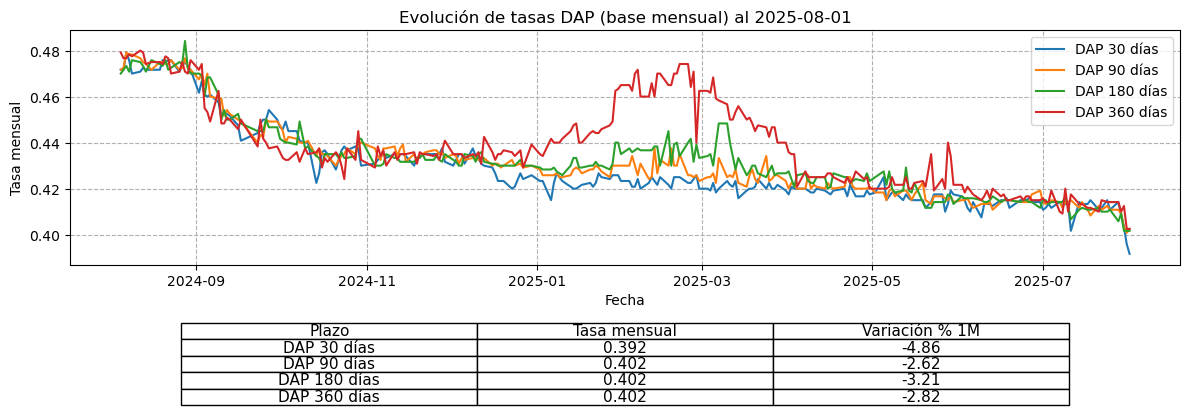

In [ ]:
from datetime import timedelta

# --- Graficar historia de tasas DAP ---
plt.figure(figsize=(12, 6))

for col in df_dap.columns:
    plt.plot(df_dap.index, df_dap[col], label=col)

# --- Fecha actual ---
fecha_actual = df_dap.index[-1]

plt.title(f"Evolución de tasas DAP (base mensual) al {fecha_actual.date()}")
plt.xlabel("Fecha")
plt.ylabel("Tasa mensual")
plt.legend()
plt.grid(linestyle="--")
plt.tight_layout()

# --- Crear tabla con los últimos valores y variación mensual ---
fecha_mes_atras = fecha_actual - timedelta(days=30)
fecha_mes_atras = df_dap.index[df_dap.index.get_loc(fecha_mes_atras, method="nearest")]

tasas_actuales = df_dap.loc[fecha_actual]
tasas_anteriores = df_dap.loc[fecha_mes_atras]

variacion_pct = ((tasas_actuales - tasas_anteriores) / tasas_anteriores * 100).round(2)
ultimos_valores = tasas_actuales.round(3)

# Crear DataFrame de tabla
tabla_datos = pd.DataFrame({
    "Plazo": ultimos_valores.index,
    "Tasa mensual": ultimos_valores.values,
    "Variación % 1M": variacion_pct.values
})

# --- Agregar tabla debajo del gráfico con espaciado adicional ---
tabla = plt.table(cellText=tabla_datos.values,
                  colLabels=tabla_datos.columns,
                  cellLoc="center",
                  loc="bottom",
                  bbox=[0.1, -0.6, 0.8, 0.35])  # Más abajo y más grande

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.5)

# Ajustar espacio inferior para la tabla
plt.subplots_adjust(bottom=0.55)
plt.show()


In [ ]:
# --- Agregar punto de 1 día a df_dap usando la TPM ya obtenida ---

# Crear copia de df_dap
df_dap_con_tpm = df_dap.copy()

# Agregar la columna de TPM como DAP 1 día
df_dap_con_tpm["DAP 1 día"] = tpm_valor / 12 # Usa la variable que ya calculaste

# Reordenar columnas para que la de 1 día quede al inicio
cols_ordenadas = ["DAP 1 día"] + [c for c in df_dap.columns]
df_dap_con_tpm = df_dap_con_tpm[cols_ordenadas]

# Ahora df_dap_con_tpm tiene: 1 día, 30, 90, 180 y 360 días

C:\Users\lappiani\AppData\Local\Temp\ipykernel_15252\2605754306.py:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  fecha_mes_atras = df_dap.index[df_dap.index.get_loc(fecha_mes_atras, method="nearest")]
c:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


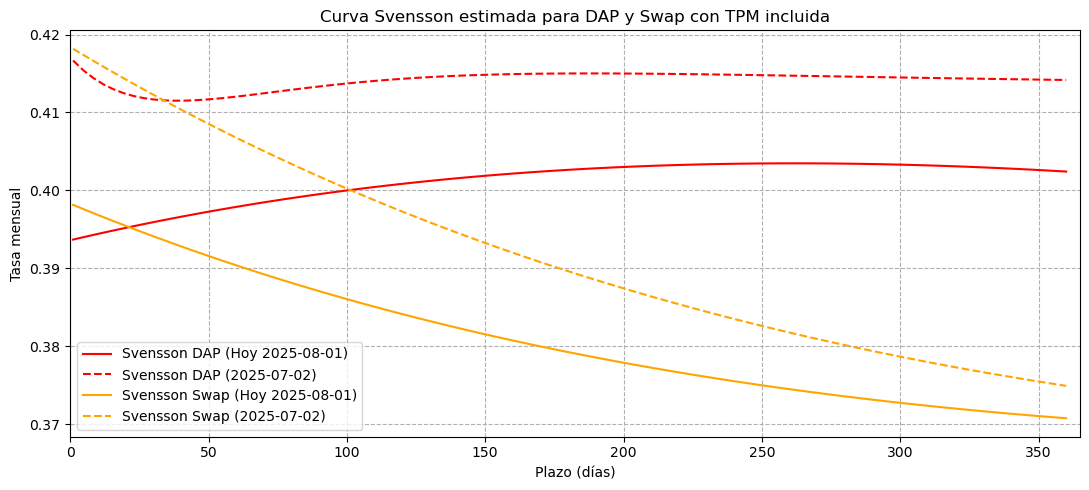

In [ ]:
from datetime import timedelta

# --- Fechas de análisis ---
fecha_actual = df_dap.index[-1]
fecha_mes_atras = fecha_actual - timedelta(days=30)
fecha_mes_atras = df_dap.index[df_dap.index.get_loc(fecha_mes_atras, method="nearest")]

# --- Función para obtener TPM mensual para una fecha dada ---
def obtener_tpm_mensual(fecha):
    df_tpm_fecha = siete.cuadro(
        series=["F022.TPM.TIN.D001.NO.Z.D"],
        nombres=["TPM"],
        desde=fecha.strftime("%Y-%m-%d"),
        hasta=fecha.strftime("%Y-%m-%d"),
        frecuencia="D",
        observado={"TPM": "last"}
    )
    return df_tpm_fecha.iloc[-1, 0] / 12  # Conversión a base mensual

# --- Obtener TPM para ambas fechas ---
tpm_actual = obtener_tpm_mensual(fecha_actual)
tpm_mes_atras = obtener_tpm_mensual(fecha_mes_atras)

# --- Crear DataFrames con TPM incluida ---
def agregar_tpm(df, fecha, tpm):
    df_con_tpm = df.copy()
    df_con_tpm["DAP 1 día"] = tpm
    cols_ordenadas = ["DAP 1 día"] + [c for c in df.columns]
    return df_con_tpm[cols_ordenadas].loc[fecha]

tasas_actual = agregar_tpm(df_dap, fecha_actual, tpm_actual).values
tasas_mes_atras = agregar_tpm(df_dap, fecha_mes_atras, tpm_mes_atras).values

# --- Plazos DAP ---
plazos_dias = np.array([1, 30, 90, 180, 360])
plazos_anos = plazos_dias / 365

# --- Estimar Svensson para DAP ---
params_svensson_actual = estimate_svensson_params(plazos_anos, tasas_actual)
params_svensson_mes_atras = estimate_svensson_params(plazos_anos, tasas_mes_atras)

# --- Generar curvas DAP ---
rango_dias = np.linspace(1, 360, 100)
rango_anos = rango_dias / 365
yields_svensson_actual = svensson_yield(rango_anos, *params_svensson_actual)
yields_svensson_mes_atras = svensson_yield(rango_anos, *params_svensson_mes_atras)

# --- Obtener tasas swap (SPC) y llevarlas a base mensual ---
tasas_swap_actual = df_spc.loc[fecha_actual].values / 12
tasas_swap_mes_atras = df_spc.loc[fecha_mes_atras].values / 12

# --- Agregar TPM como punto de 1 día a las curvas swap ---
tasas_swap_actual = np.insert(tasas_swap_actual, 0, tpm_actual)
tasas_swap_mes_atras = np.insert(tasas_swap_mes_atras, 0, tpm_mes_atras)

# Plazos swap
plazos_swap_anos = np.insert(np.array([0.25, 0.5, 1, 2, 3, 4, 5, 10]), 0, 1/365)
plazos_swap_dias = plazos_swap_anos * 365

# --- Estimar Svensson para Swap ---
params_swap_actual = estimate_svensson_params(plazos_swap_anos, tasas_swap_actual)
params_swap_mes_atras = estimate_svensson_params(plazos_swap_anos, tasas_swap_mes_atras)

# --- Generar curvas Swap ---
yields_swap_actual = svensson_yield(rango_anos, *params_swap_actual)
yields_swap_mes_atras = svensson_yield(rango_anos, *params_swap_mes_atras)

# --- Graficar ---
plt.figure(figsize=(11, 5))

# Curvas Svensson DAP
plt.plot(rango_dias, yields_svensson_actual, color="red", label=f"Svensson DAP (Hoy {fecha_actual.date()})")
plt.plot(rango_dias, yields_svensson_mes_atras, color="red", linestyle="--", label=f"Svensson DAP ({fecha_mes_atras.date()})")

# Curvas Svensson Swap
plt.plot(rango_dias, yields_swap_actual, color="orange", label=f"Svensson Swap (Hoy {fecha_actual.date()})")
plt.plot(rango_dias, yields_swap_mes_atras, color="orange", linestyle="--", label=f"Svensson Swap ({fecha_mes_atras.date()})")

# Configuración del gráfico
plt.xlabel("Plazo (días)")
plt.ylabel("Tasa mensual")
plt.title("Curva Svensson estimada para DAP y Swap con TPM incluida")
plt.xlim(0, 365)  # Limitar a 1 año
plt.grid(linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()
